In [ ]:
import pandas as pd
import numpy as np
import transformers
import re
from matplotlib import pyplot as plt

In [ ]:
stat = pd.read_csv("C:/Users/aredko/Downloads/CoronavirusPL - General.csv")
twits = pd.read_csv("C:/Users/aredko/Downloads/tweets_till_31_07_text/tweets_till_31_07_text.csv", encoding='latin1')

In [ ]:
twits['clean_text'] = twits['text'].apply(lambda x: re.sub(r'#\w+', '', x))

In [ ]:
stat

,Timestamp,Confirmed,Deaths,Recovered,In_the_hospital,In_quarantine,Under_medical_supervision,Number_of_tests_carried_out
0,03-03-2020,0,0,0,68,316,4459,559
1,04-03-2020,1,0,0,65,349,4540,584
2,05-03-2020,1,0,0,92,490,5647,676
3,06-03-2020,5,0,0,128,1299,6184,855
4,07-03-2020,6,0,0,146,1548,6409,856
...,...,...,...,...,...,...,...,...
102,13-06-2020,29017,1237,9416,1748,93094,18666,1169088
103,14-06-2020,29392,1247,9555,1736,94518,17966,1188742
104,15-06-2020,29788,1256,9668,1806,95641,17261,1202024
105,16-06-2020,30195,1272,9936,1693,96255,17195,1221133


In [ ]:
twits = twits[(twits.time > '2020-03-03 00:00:01') & (twits.time < '2020-06-17 00:00:01')]

In [ ]:
twits

,Unnamed: 0,text,time,clean_text
26099,26100,"Andrzej Sosnierz: Nie wiem, na jakiej podstawi...",2020-05-29 00:08:42,"Andrzej Sosnierz: Nie wiem, na jakiej podstawi..."
26100,26101,Afera Argenty to rzadowe zakupy (po paserskich...,2020-05-29 00:03:07,Afera Argenty to rzadowe zakupy (po paserskich...
26101,26102,prezencik dla kuchcinskiego i innych pedofili ...,2020-05-29 00:02:35,prezencik dla kuchcinskiego i innych pedofili ...
26102,26103,prezencik dla kuchcinskiego i innych pedofili ...,2020-05-28 23:58:17,prezencik dla kuchcinskiego i innych pedofili ...
26103,26104,Swiatowej slawy prawnik  David Matas  tlumac...,2020-05-28 23:55:47,Swiatowej slawy prawnik  David Matas  tlumac...
...,...,...,...,...
1015194,1015195,"Wiceminister rolnictwa nareszcie przyznal, ze ...",2020-05-29 00:37:29,"Wiceminister rolnictwa nareszcie przyznal, ze ..."
1015195,1015196,"Andrzej Sosnierz: Nie wiem, na jakiej podstawi...",2020-05-29 00:33:01,"Andrzej Sosnierz: Nie wiem, na jakiej podstawi..."
1015196,1015197,Afera Argenty to rzadowe zakupy (po paserskich...,2020-05-29 00:29:55,Afera Argenty to rzadowe zakupy (po paserskich...
1015197,1015198,#wtylewizji #pandemia #koronawirus #obostrzeni...,2020-05-29 00:28:21,"jedyny, ktory nie czeka na otwarc..."


In [ ]:
clean_tweet

'Rekordowa frekwencja? Przeciez mamy WIELKA EPIDEMIE! Ludzie otworzcie oczy! Bo sami sobie przeczycie!        '

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("bardsai/twitter-sentiment-pl-base")
model = AutoModelForSequenceClassification.from_pretrained("bardsai/twitter-sentiment-pl-base")
#citizenlab/twitter-xlm-roberta-base-sentiment-finetunned

#tokenizer = AutoTokenizer.from_pretrained("citizenlab/twitter-xlm-roberta-base-sentiment-finetunned")
#model = AutoModelForSequenceClassification.from_pretrained("citizenlab/twitter-xlm-roberta-base-sentiment-finetunned")

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader


class MyDataset(Dataset):
    def __init__(self, tokenizer, input_texts, max_length=128):
        self.tokenizer = tokenizer
        self.input_texts = input_texts
        self.max_length = max_length

    def __len__(self):
        return len(self.input_texts)

    def __getitem__(self, idx):
        input_text = self.input_texts[idx]

        # Кодирование для seq2seq задачи
        encoding = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
        }

In [ ]:
eval_texts = twits.clean_text.values

In [ ]:
dataset = MyDataset(tokenizer, eval_texts)
loader = DataLoader(dataset, batch_size=128, shuffle=False)

In [ ]:
device = 'cuda'
res = []
model = model.eval().to(device)
with torch.no_grad():
    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits.detach().to('cpu')
        res.append(outputs)

In [ ]:
preds = np.concatenate(res).argmax(axis = -1)

In [ ]:
negatives = preds==2
posetive = preds==0
neutral = preds== 1

In [ ]:
twits['neg'] = negatives

In [ ]:
twits['preds'] = preds

In [ ]:
twits['time'] = pd.to_datetime(twits['time'])

# Группировка по дням и вычисление среднего значения столбца 'predict'
df_grouped = pd.DataFrame(twits.groupby(twits['time'].dt.date)['preds'].mean()/2)
df_grouped2 = pd.DataFrame(twits.groupby(twits['time'].dt.date)['neg'].sum())
df_grouped3 = pd.DataFrame(twits.groupby(twits['time'].dt.date)['neg'].mean())

df_grouped = df_grouped.reset_index()
df_grouped['time'] = pd.to_datetime(df_grouped['time'])

df_grouped3 = df_grouped3.reset_index()
df_grouped3['time'] = pd.to_datetime(df_grouped3['time'])

df_grouped2 = df_grouped2.reset_index()
df_grouped2['time'] = pd.to_datetime(df_grouped2['time'])

In [ ]:
df_grouped3.columns = ['time','neg_perc']

In [ ]:
stat['time'] = pd.to_datetime(stat['Timestamp'], format='%d-%m-%Y')

In [ ]:
stat = stat[:-1]

In [ ]:
merged_df = stat.merge(df_grouped, left_on = 'time', right_on = 'time')
merged_df = merged_df.merge(df_grouped2, left_on = 'time', right_on = 'time')
merged_df = merged_df.merge(df_grouped3, left_on = 'time', right_on = 'time')

In [ ]:
merged_df['preds'] = 1-merged_df['preds']

In [ ]:
merged_df.to_csv('twits_twitter_sentiment_model.csv')

In [ ]:
merged_df['Deaths_value'] = merged_df['Deaths'].diff()

# Заполнение пропущенного значения первого дня
merged_df.loc[0, 'Deaths_value'] = merged_df.loc[0, 'Deaths']

In [ ]:
merged_df

,Timestamp,Confirmed,Deaths,Recovered,In_the_hospital,In_quarantine,Under_medical_supervision,Number_of_tests_carried_out,time,preds,neg,neg_perc,Deaths_value
0,03-03-2020,0,0,0,68,316,4459,559,2020-03-03,0.376035,2008,0.369321,0.0
1,04-03-2020,1,0,0,65,349,4540,584,2020-03-04,0.448035,2625,0.265904,0.0
2,05-03-2020,1,0,0,92,490,5647,676,2020-03-05,0.364300,2202,0.391885,0.0
3,06-03-2020,5,0,0,128,1299,6184,855,2020-03-06,0.372014,2232,0.362750,0.0
4,07-03-2020,6,0,0,146,1548,6409,856,2020-03-07,0.349968,1913,0.409724,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,12-06-2020,28577,1222,9221,1711,92654,18904,1150983,2020-06-12,0.412659,453,0.320368,7.0
102,13-06-2020,29017,1237,9416,1748,93094,18666,1169088,2020-06-13,0.355713,467,0.389491,15.0
103,14-06-2020,29392,1247,9555,1736,94518,17966,1188742,2020-06-14,0.465323,129,0.208065,10.0
104,15-06-2020,29788,1256,9668,1806,95641,17261,1202024,2020-06-15,0.415623,414,0.272907,9.0


In [ ]:
In_quarantine = merged_df.In_quarantine.values
In_the_hospital = merged_df.In_the_hospital.values
Confirmed = merged_df.Confirmed.values
Deaths = merged_df.Deaths.values
Number_of_tests_carried_out = merged_df.Number_of_tests_carried_out.values
#Deaths_value = merged_df.Deaths_value.values
Recovered = merged_df.Recovered.values
Under_medical_supervision = merged_df.Under_medical_supervision.values
time =  merged_df.time.values
sentiment_mean = merged_df.preds.values
sentiment_neg = merged_df.neg.values
neg_perc = merged_df.neg_perc.values

Text(0, 0.5, 'In_quarantine')

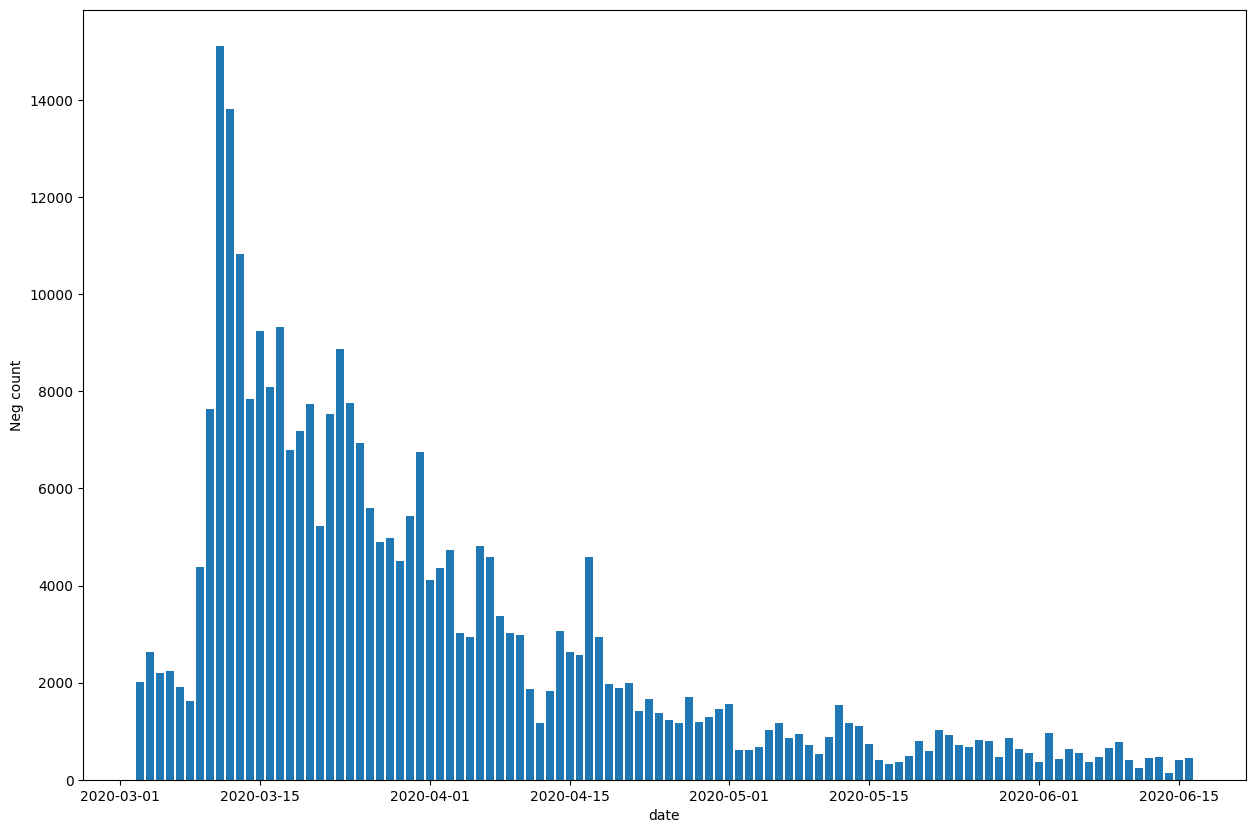

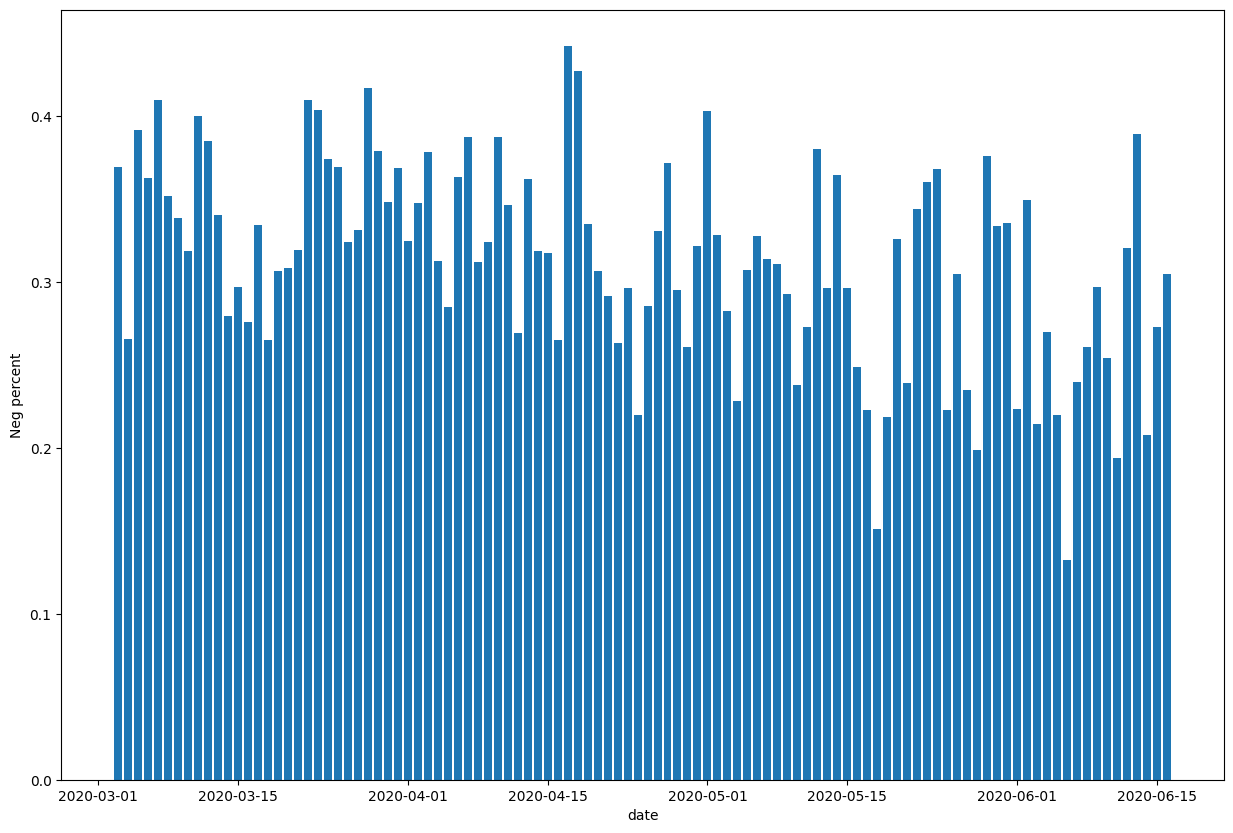

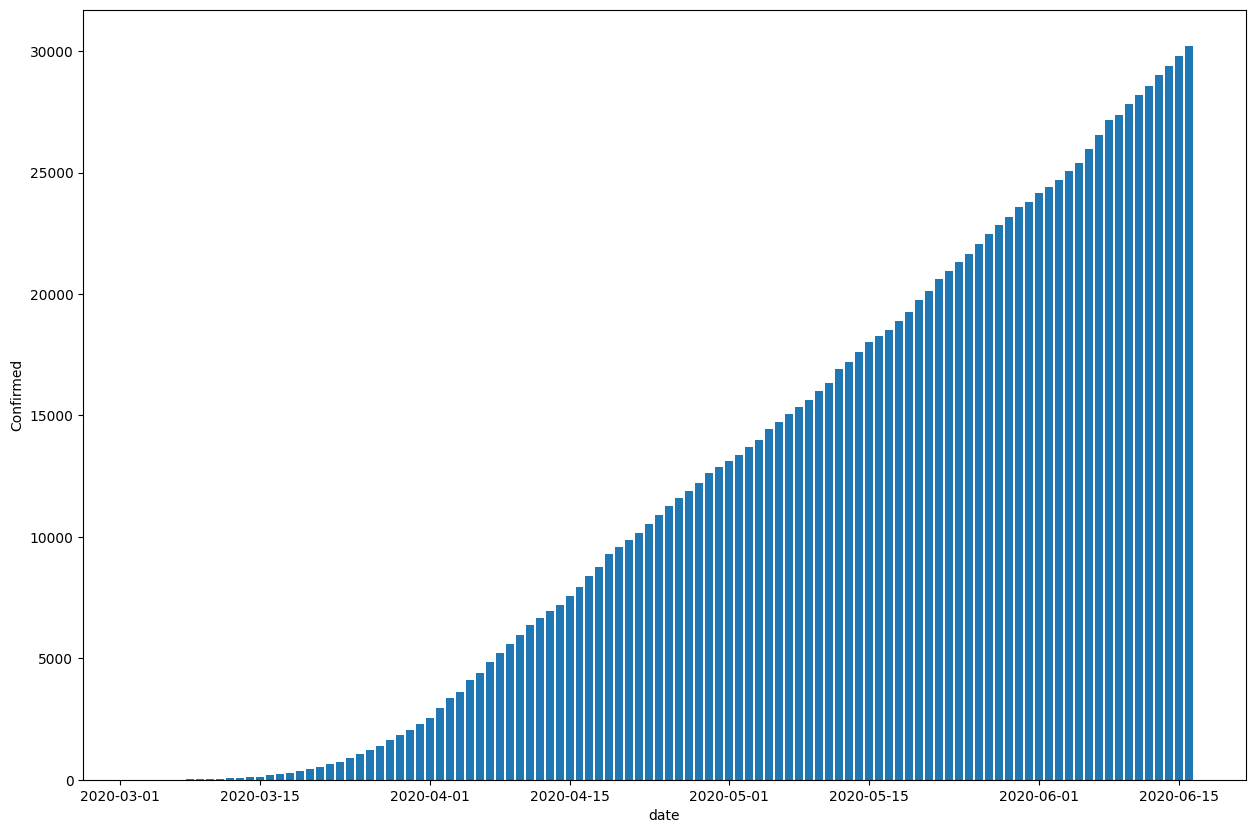

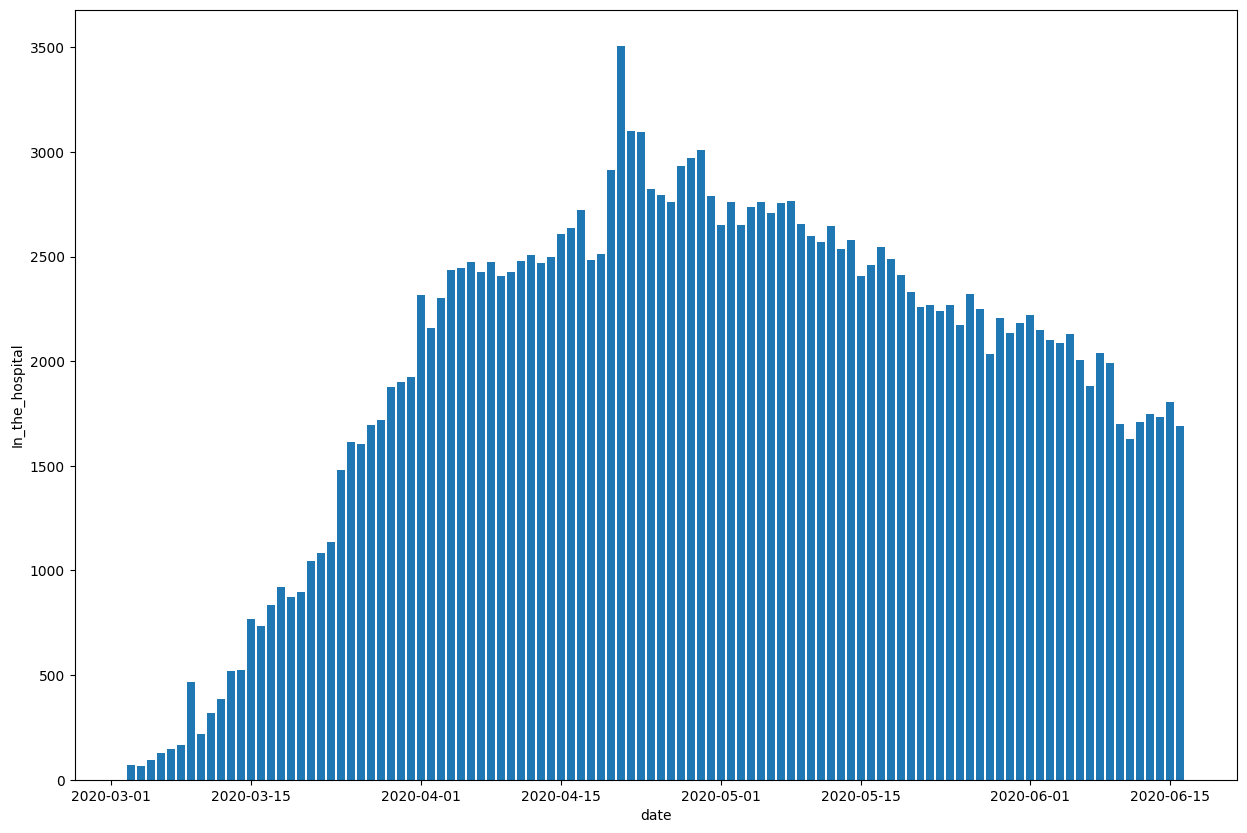

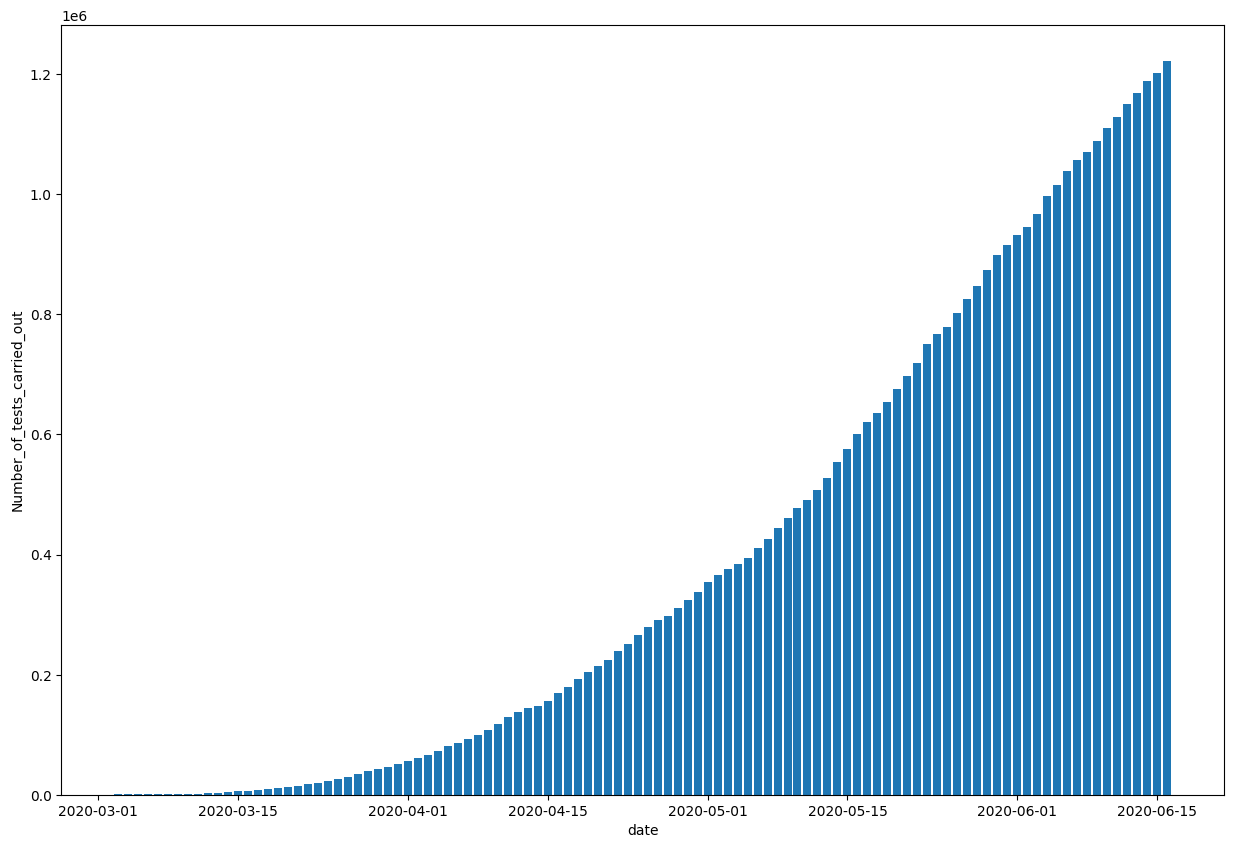

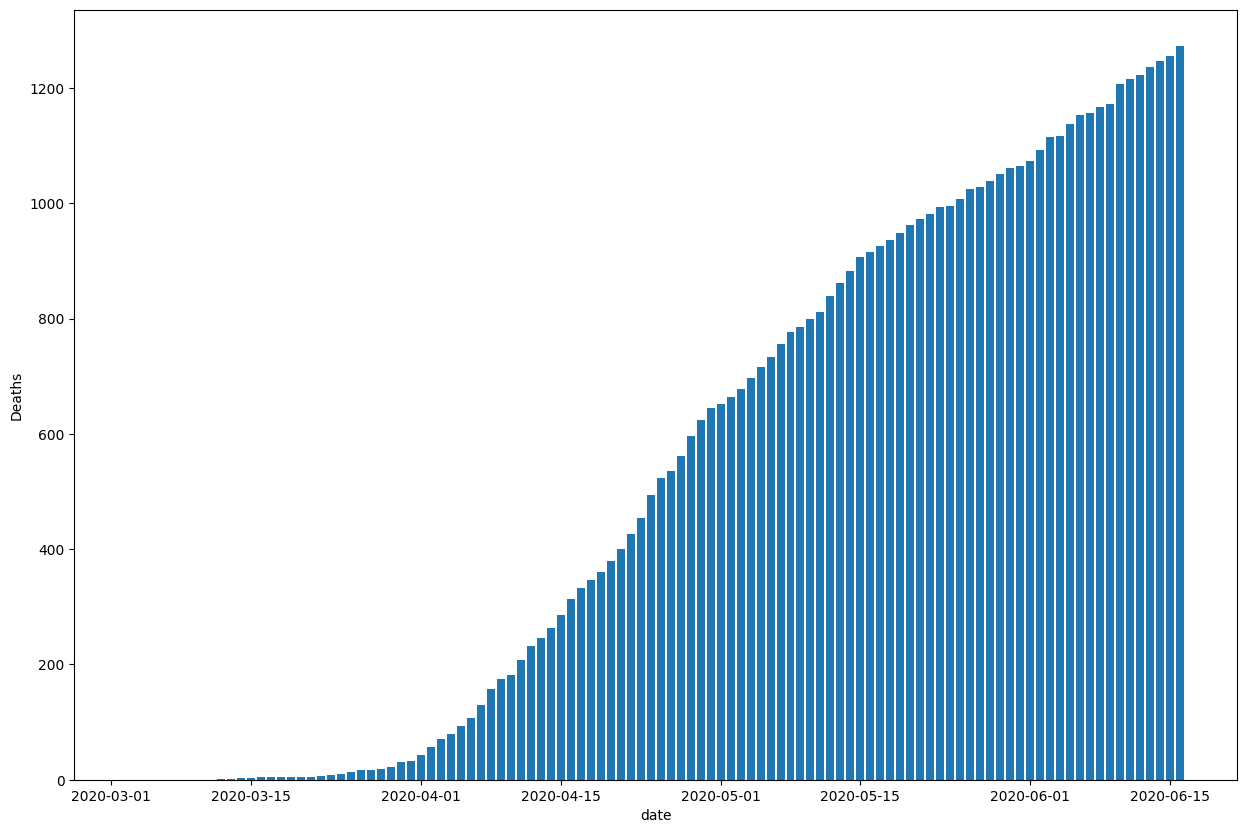

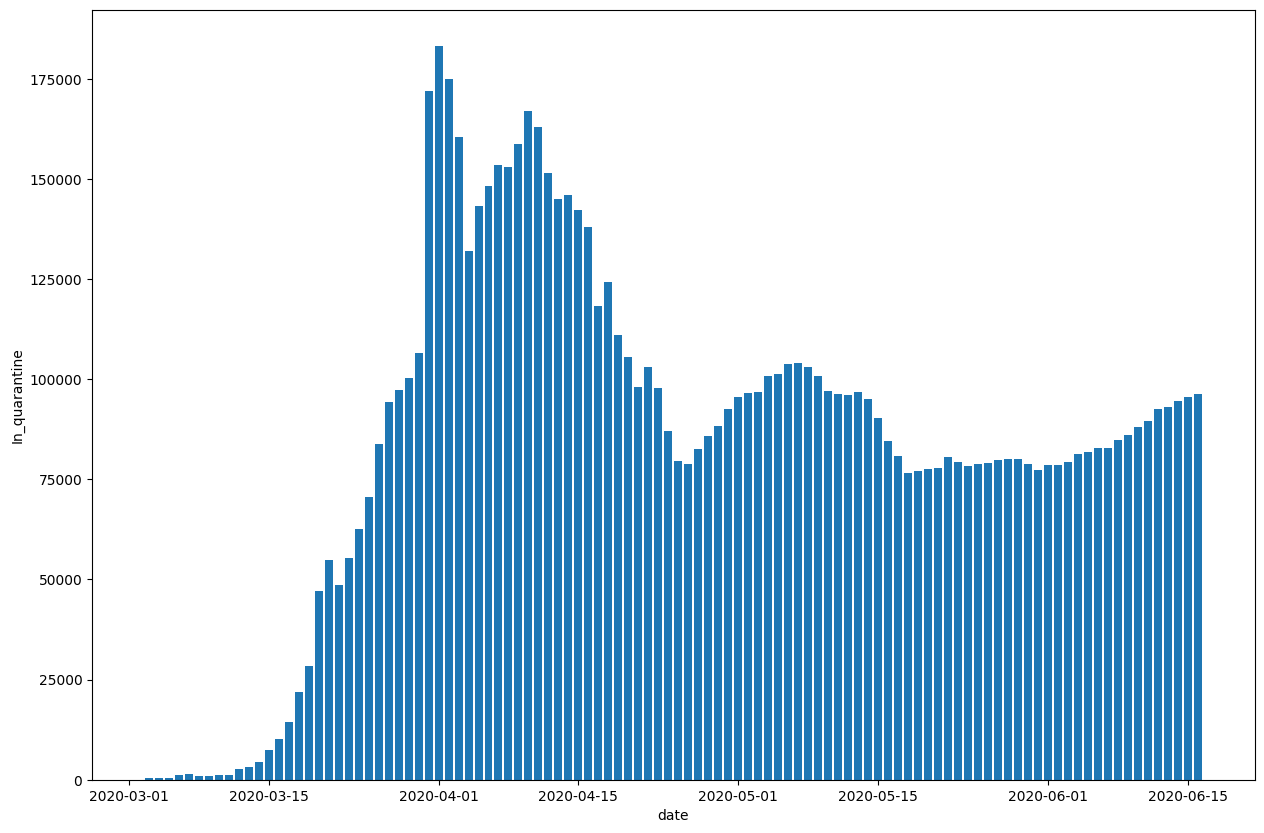

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
plt.bar(time, sentiment_neg)
#plt.xticks(rotation=90)
max_xticks = 6
#x_step = len(sentiment_neg) // max_xticks
#plt.xticks(range(0, len(sentiment_neg), x_step))
plt.xlabel('date')
#plt.yscale('log')
plt.ylabel('Neg count')

fig, ax = plt.subplots(figsize = (15,10))
plt.bar(time, neg_perc)
#plt.xticks(rotation=90)
max_xticks = 6
#x_step = len(sentiment_neg) // max_xticks
#plt.xticks(range(0, len(sentiment_neg), x_step))
plt.xlabel('date')
#plt.yscale('log')
plt.ylabel('Neg percent')

fig, ax = plt.subplots(figsize = (15,10))
plt.bar(time, Confirmed)
#plt.xticks(rotation=90)
max_xticks = 6
#x_step = len(sentiment_neg) // max_xticks
#plt.xticks(range(0, len(sentiment_neg), x_step))
plt.xlabel('date')
plt.ylabel('Confirmed')

fig, ax = plt.subplots(figsize = (15,10))
plt.bar(time, In_the_hospital)
#plt.xticks(rotation=90)
max_xticks = 6
#x_step = len(sentiment_neg) // max_xticks
#plt.xticks(range(0, len(sentiment_neg), x_step))
plt.xlabel('date')
plt.ylabel('In_the_hospital')

fig, ax = plt.subplots(figsize = (15,10))
plt.bar(time, Number_of_tests_carried_out)
#plt.xticks(rotation=90)
max_xticks = 6
#x_step = len(sentiment_neg) // max_xticks
#plt.xticks(range(0, len(sentiment_neg), x_step))
plt.xlabel('date')
plt.ylabel('Number_of_tests_carried_out')

fig, ax = plt.subplots(figsize = (15,10))
plt.bar(time, Deaths)
#plt.xticks(rotation=90)
max_xticks = 6
#x_step = len(sentiment_neg) // max_xticks
#plt.xticks(range(0, len(sentiment_neg), x_step))
plt.xlabel('date')
plt.ylabel('Deaths')

fig, ax = plt.subplots(figsize = (15,10))
plt.bar(time, In_quarantine)
#plt.xticks(rotation=90)
max_xticks = 6
#x_step = len(sentiment_neg) // max_xticks
#plt.xticks(range(0, len(sentiment_neg), x_step))
plt.xlabel('date')
plt.ylabel('In_quarantine')

In [ ]:
import pandas as pd
from scipy.stats import pearsonr

In [ ]:
merged_df.columns[1:8]

Index(['Confirmed', 'Deaths', 'Recovered', 'In_the_hospital', 'In_quarantine',
       'Under_medical_supervision', 'Number_of_tests_carried_out'],
      dtype='object')

In [ ]:
for column in merged_df.columns[1:8]:
    print(f"{column} and Neg posts sum: {pearsonr(sentiment_neg, merged_df[column].values)}")

Confirmed and Neg posts sum: PearsonRResult(statistic=-0.7302082221697693, pvalue=9.716623045397477e-19)
Deaths and Neg posts sum: PearsonRResult(statistic=-0.7353346673563388, pvalue=4.1847696556432106e-19)
Recovered and Neg posts sum: PearsonRResult(statistic=-0.6189927052957027, pvalue=1.9522363949682964e-12)
In_the_hospital and Neg posts sum: PearsonRResult(statistic=-0.5821356467179359, pvalue=7.346530435476609e-11)
In_quarantine and Neg posts sum: PearsonRResult(statistic=-0.35901882899994997, pvalue=0.00016923168245210258)
Under_medical_supervision and Neg posts sum: PearsonRResult(statistic=0.4572174595517594, pvalue=9.432339423109382e-07)
Number_of_tests_carried_out and Neg posts sum: PearsonRResult(statistic=-0.6556914834150495, pvalue=3.1819487582467283e-14)


In [ ]:
for column in merged_df.columns[1:8]:
    print(f"{column} and Neg posts sum: {pearsonr(neg_perc, merged_df[column].values)}")

Confirmed and Neg posts sum: PearsonRResult(statistic=-0.4892199323813092, pvalue=1.1860466581313154e-07)
Deaths and Neg posts sum: PearsonRResult(statistic=-0.4978489567329055, pvalue=6.533946059846299e-08)
Recovered and Neg posts sum: PearsonRResult(statistic=-0.4806290563971753, pvalue=2.1130222653150772e-07)
In_the_hospital and Neg posts sum: PearsonRResult(statistic=-0.20908458547749692, pvalue=0.032310208840362176)
In_quarantine and Neg posts sum: PearsonRResult(statistic=0.002396452152433952, pvalue=0.980643298331482)
Under_medical_supervision and Neg posts sum: PearsonRResult(statistic=0.24639653010658907, pvalue=0.01128386938633613)
Number_of_tests_carried_out and Neg posts sum: PearsonRResult(statistic=-0.48364120962260654, pvalue=1.7288091283017344e-07)


In [ ]:
def smooth_column(column, window_size):
    smoothed_column = column.rolling(window=window_size, min_periods=1).mean()
    return smoothed_column

# Пример использования функции
window_size = 30

for column in merged_df.columns:
    if(column not in ['time', 'Timestamp']):
        smoothed_values = smooth_column(merged_df[column], window_size)
        merged_df[column] = smoothed_values

In [ ]:
In_quarantine = merged_df.In_quarantine.values
In_the_hospital = merged_df.In_the_hospital.values
Confirmed = merged_df.Confirmed.values
Deaths = merged_df.Deaths.values
Number_of_tests_carried_out = merged_df.Number_of_tests_carried_out.values
#Deaths_value = merged_df.Deaths_value.values
Recovered = merged_df.Recovered.values
Under_medical_supervision = merged_df.Under_medical_supervision.values
time =  merged_df.time.values
sentiment_mean = merged_df.preds.values
sentiment_neg = merged_df.neg.values
neg_perc = merged_df.neg_perc.values

Text(0, 0.5, 'In_quarantine')

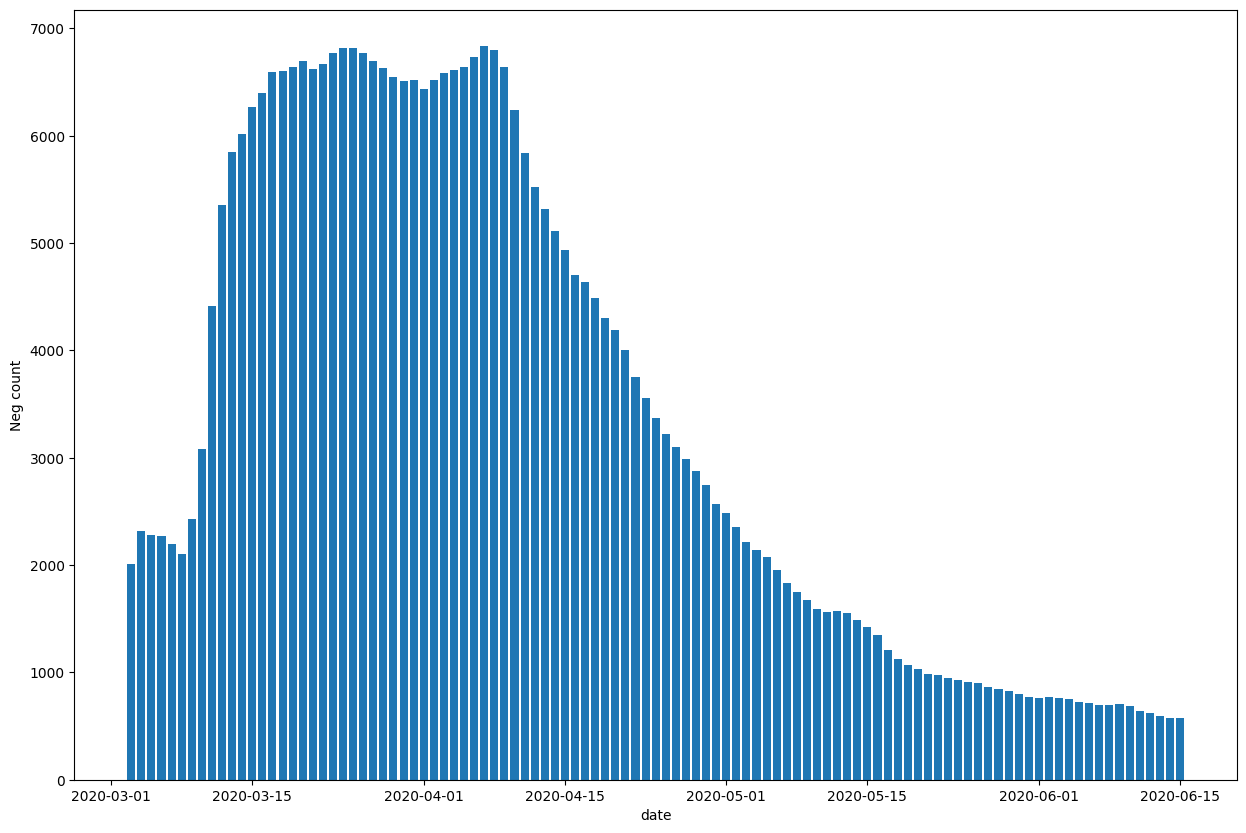

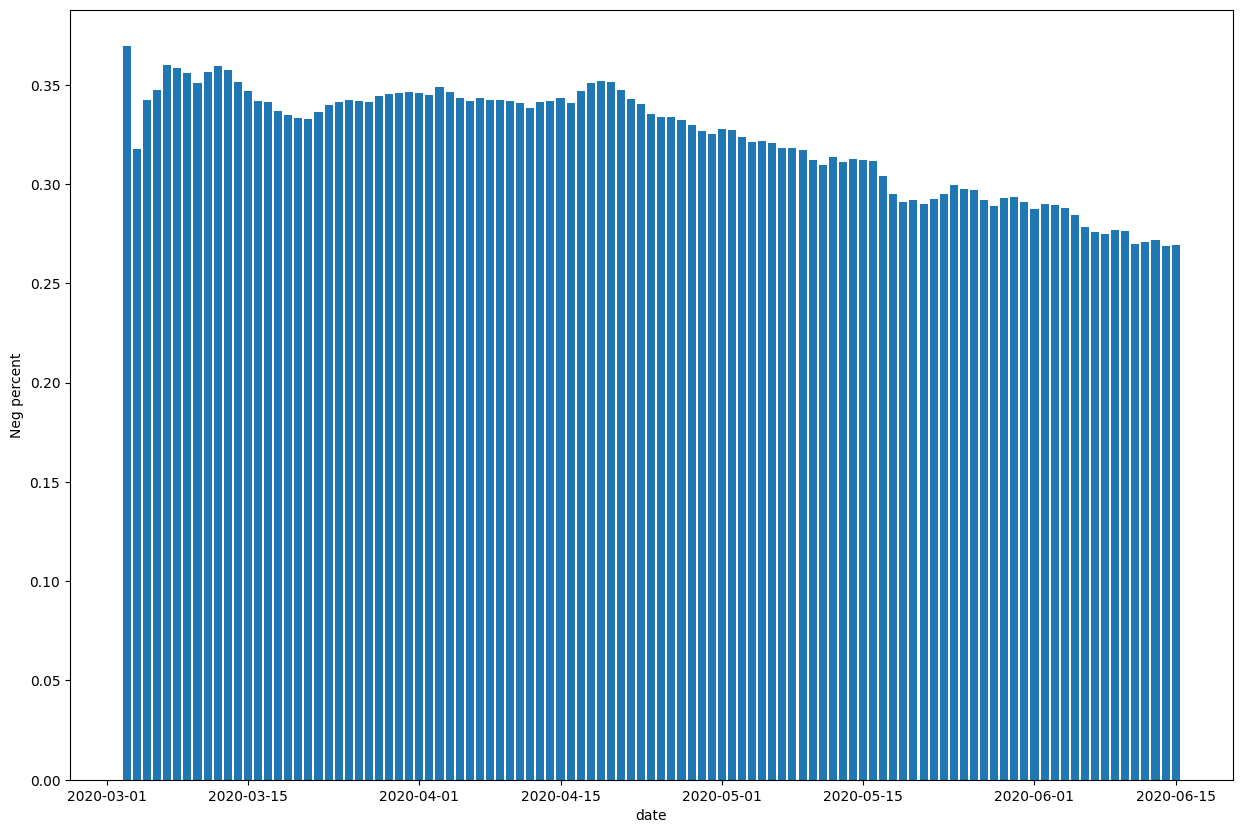

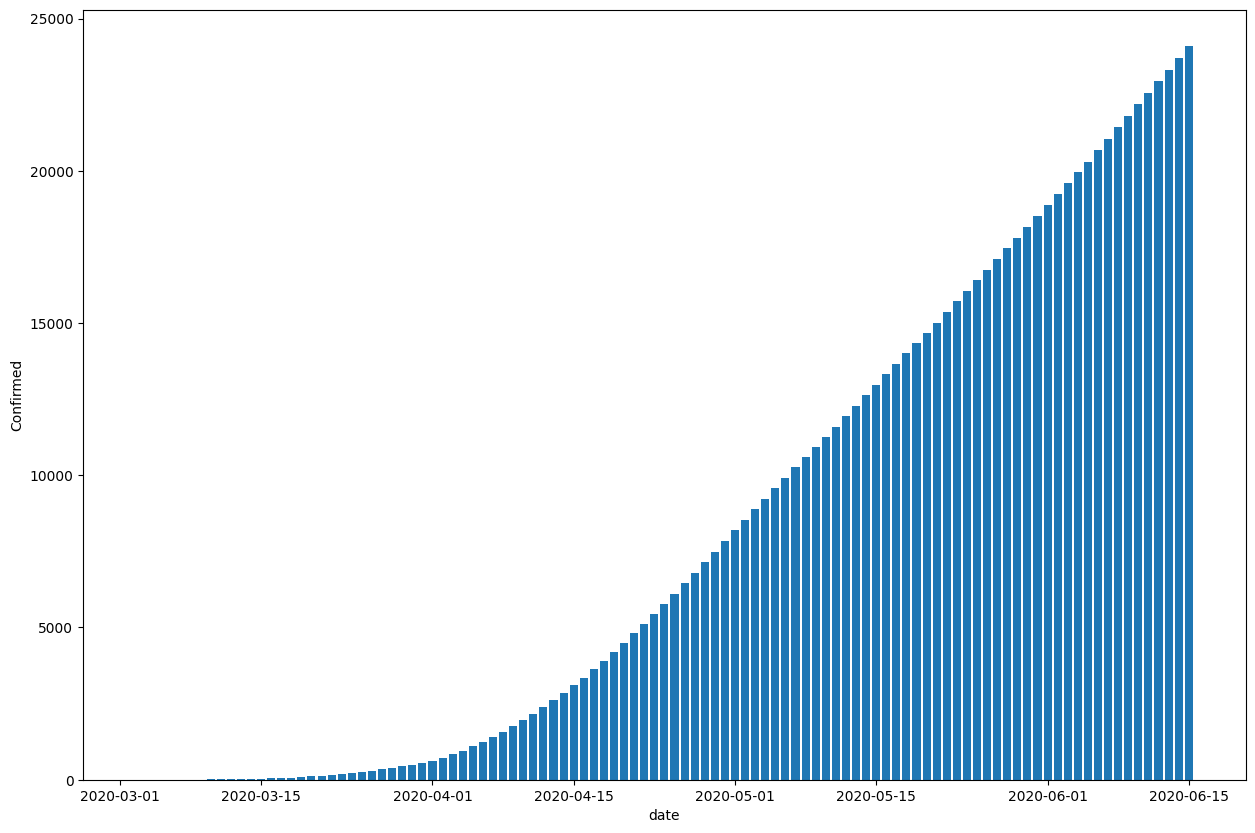

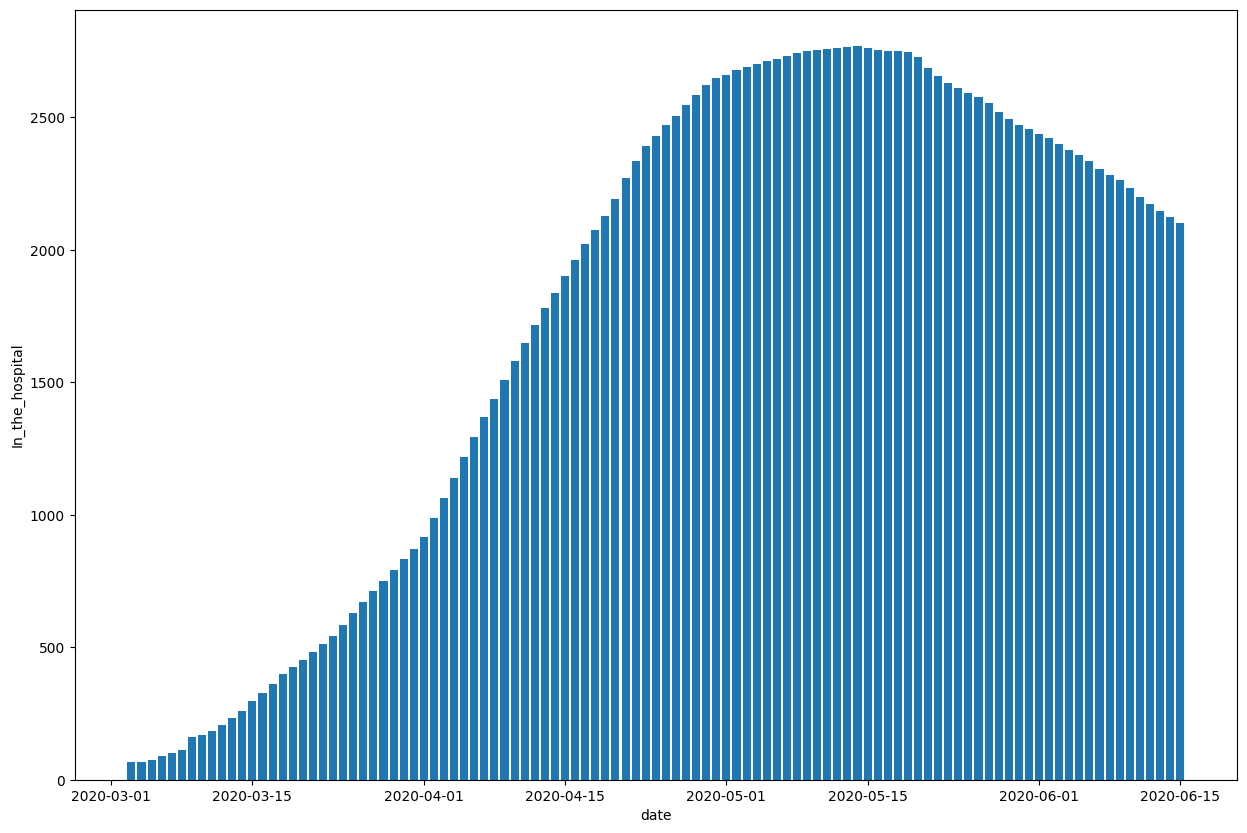

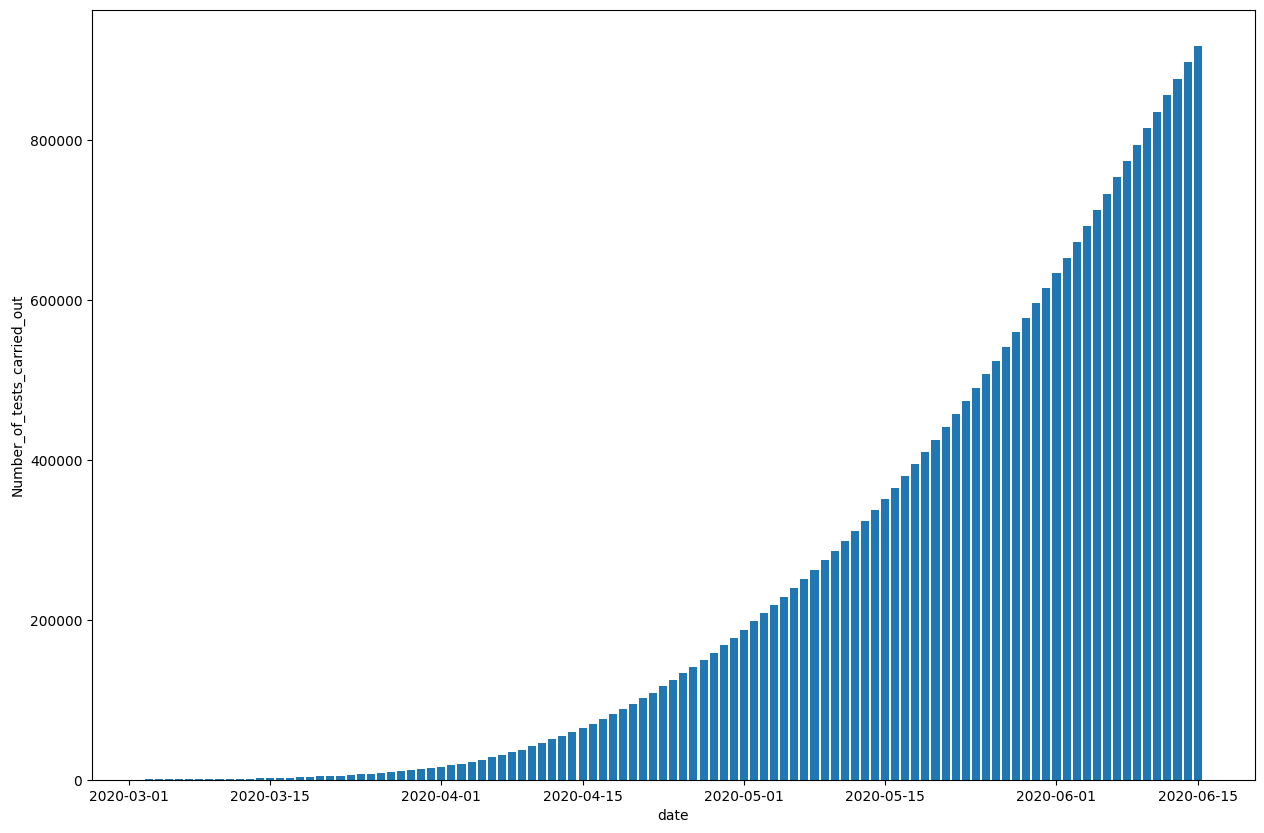

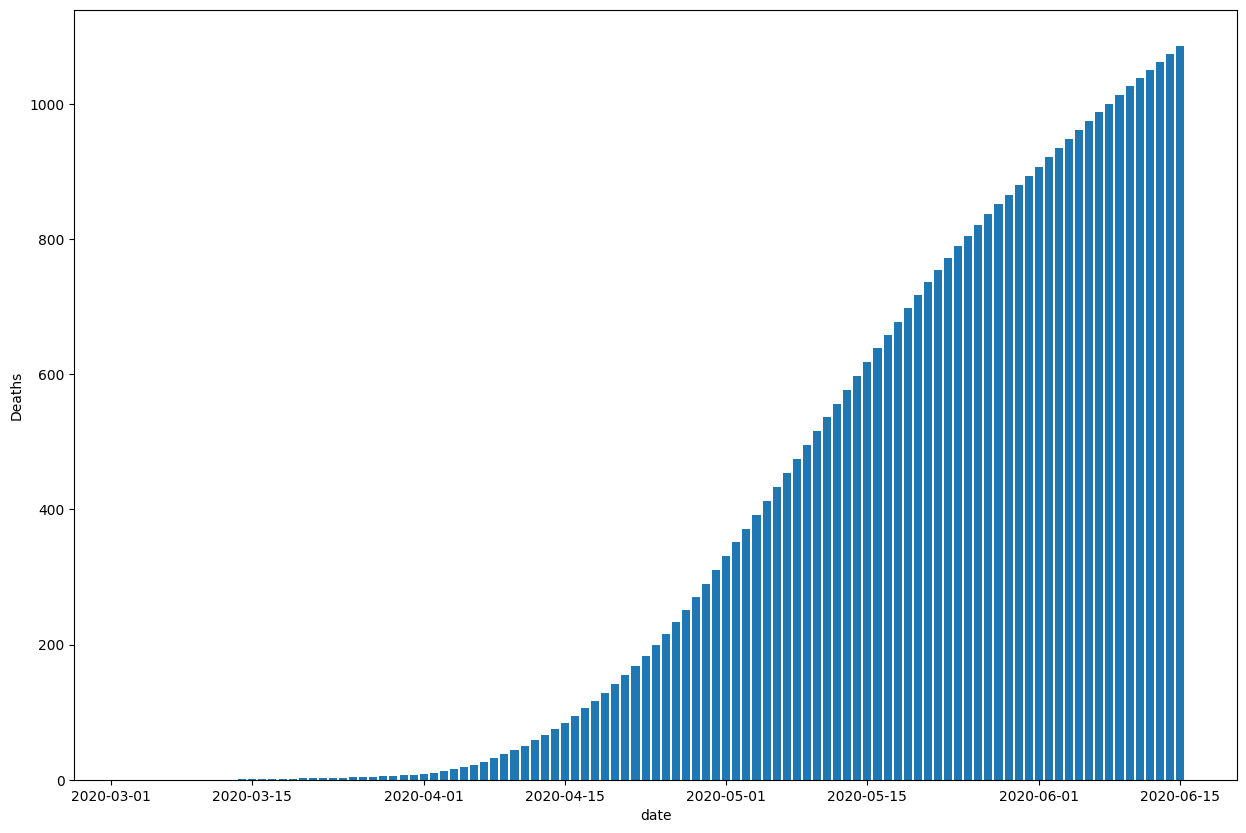

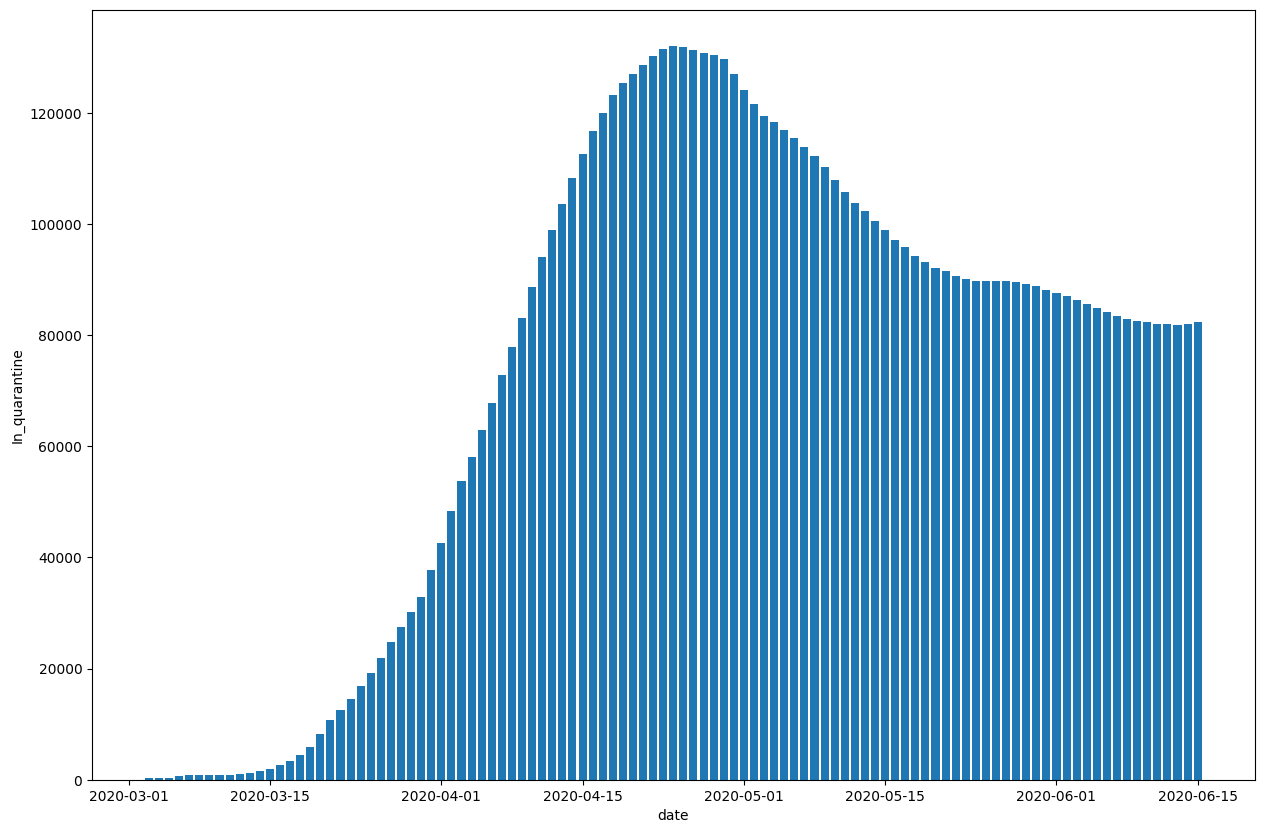

In [ ]:
fig, ax = plt.subplots(figsize = (15,10))
plt.bar(time, sentiment_neg)
#plt.xticks(rotation=90)
max_xticks = 6
#x_step = len(sentiment_neg) // max_xticks
#plt.xticks(range(0, len(sentiment_neg), x_step))
plt.xlabel('date')
#plt.yscale('log')
plt.ylabel('Neg count')

fig, ax = plt.subplots(figsize = (15,10))
plt.bar(time, neg_perc)
#plt.xticks(rotation=90)
max_xticks = 6
#x_step = len(sentiment_neg) // max_xticks
#plt.xticks(range(0, len(sentiment_neg), x_step))
plt.xlabel('date')
#plt.yscale('log')
plt.ylabel('Neg percent')

fig, ax = plt.subplots(figsize = (15,10))
plt.bar(time, Confirmed)
#plt.xticks(rotation=90)
max_xticks = 6
#x_step = len(sentiment_neg) // max_xticks
#plt.xticks(range(0, len(sentiment_neg), x_step))
plt.xlabel('date')
plt.ylabel('Confirmed')

fig, ax = plt.subplots(figsize = (15,10))
plt.bar(time, In_the_hospital)
#plt.xticks(rotation=90)
max_xticks = 6
#x_step = len(sentiment_neg) // max_xticks
#plt.xticks(range(0, len(sentiment_neg), x_step))
plt.xlabel('date')
plt.ylabel('In_the_hospital')

fig, ax = plt.subplots(figsize = (15,10))
plt.bar(time, Number_of_tests_carried_out)
#plt.xticks(rotation=90)
max_xticks = 6
#x_step = len(sentiment_neg) // max_xticks
#plt.xticks(range(0, len(sentiment_neg), x_step))
plt.xlabel('date')
plt.ylabel('Number_of_tests_carried_out')

fig, ax = plt.subplots(figsize = (15,10))
plt.bar(time, Deaths)
#plt.xticks(rotation=90)
max_xticks = 6
#x_step = len(sentiment_neg) // max_xticks
#plt.xticks(range(0, len(sentiment_neg), x_step))
plt.xlabel('date')
plt.ylabel('Deaths')

fig, ax = plt.subplots(figsize = (15,10))
plt.bar(time, In_quarantine)
#plt.xticks(rotation=90)
max_xticks = 6
#x_step = len(sentiment_neg) // max_xticks
#plt.xticks(range(0, len(sentiment_neg), x_step))
plt.xlabel('date')
plt.ylabel('In_quarantine')

In [ ]:
for column in merged_df.columns[1:8]:
    print(f"{column} and Neg posts sum: {pearsonr(sentiment_neg, merged_df[column].values)}")

Confirmed and Neg posts sum: PearsonRResult(statistic=-0.8506456348665676, pvalue=1.594129865184633e-30)
Deaths and Neg posts sum: PearsonRResult(statistic=-0.8535629963972896, pvalue=6.2387918421774085e-31)
Recovered and Neg posts sum: PearsonRResult(statistic=-0.7624151243556994, pvalue=3.45609258984442e-21)
In_the_hospital and Neg posts sum: PearsonRResult(statistic=-0.6678242596849017, pvalue=7.177864759207948e-15)
In_quarantine and Neg posts sum: PearsonRResult(statistic=-0.44890091537996535, pvalue=1.5633022682846868e-06)
Under_medical_supervision and Neg posts sum: PearsonRResult(statistic=0.4641353832369639, pvalue=6.132456760585395e-07)
Number_of_tests_carried_out and Neg posts sum: PearsonRResult(statistic=-0.8014039160518103, pvalue=9.949537927243237e-25)


In [ ]:
for column in merged_df.columns[1:8]:
    print(f"{column} and Neg posts sum: {pearsonr(neg_perc, merged_df[column].values)}")

Confirmed and Neg posts sum: PearsonRResult(statistic=-0.9610441610789089, pvalue=2.448889626330691e-59)
Deaths and Neg posts sum: PearsonRResult(statistic=-0.9664850799735327, pvalue=1.2128756146834388e-62)
Recovered and Neg posts sum: PearsonRResult(statistic=-0.9481821314939642, pvalue=4.2533491074211405e-53)
In_the_hospital and Neg posts sum: PearsonRResult(statistic=-0.6418385445963984, pvalue=1.6065736976014229e-13)
In_quarantine and Neg posts sum: PearsonRResult(statistic=-0.3708383682891545, pvalue=9.849105420096153e-05)
Under_medical_supervision and Neg posts sum: PearsonRResult(statistic=0.27615678681920325, pvalue=0.004350468594450867)
Number_of_tests_carried_out and Neg posts sum: PearsonRResult(statistic=-0.9603060430235307, pvalue=6.319685301642703e-59)
